In [1]:
import csv
import numpy as np
import configparser
import matplotlib.pyplot as plt

from keras.utils import np_utils
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [2]:
config = configparser.ConfigParser()
config.read('../config/config-spyder.ini')

['../config/config-spyder.ini']

In [3]:
import sys
sys.path.insert(0, '../source/')
from Get_Train_Test_Data import GetTrainTestData
from CNN_Model import CNNModel

In [4]:
X_train, X_test, X_val, y_train, y_test, y_val = GetTrainTestData(config).read_dataset()

In [5]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], X_train.shape[2], 1).astype('float32')
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1).astype('float32')

In [6]:
X_train.shape

(750, 128, 1249, 1)

In [7]:
X_train_reshape = X_train.reshape([X_train.shape[0], np.prod(X_train.shape[1:])]).astype('float64')

In [8]:
X_train_reshape.shape

(750, 159872)

Realizamos la descomoposición PCA <br>
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit

In [9]:
X_pca = PCA(n_components = 350).fit_transform(X_train_reshape)

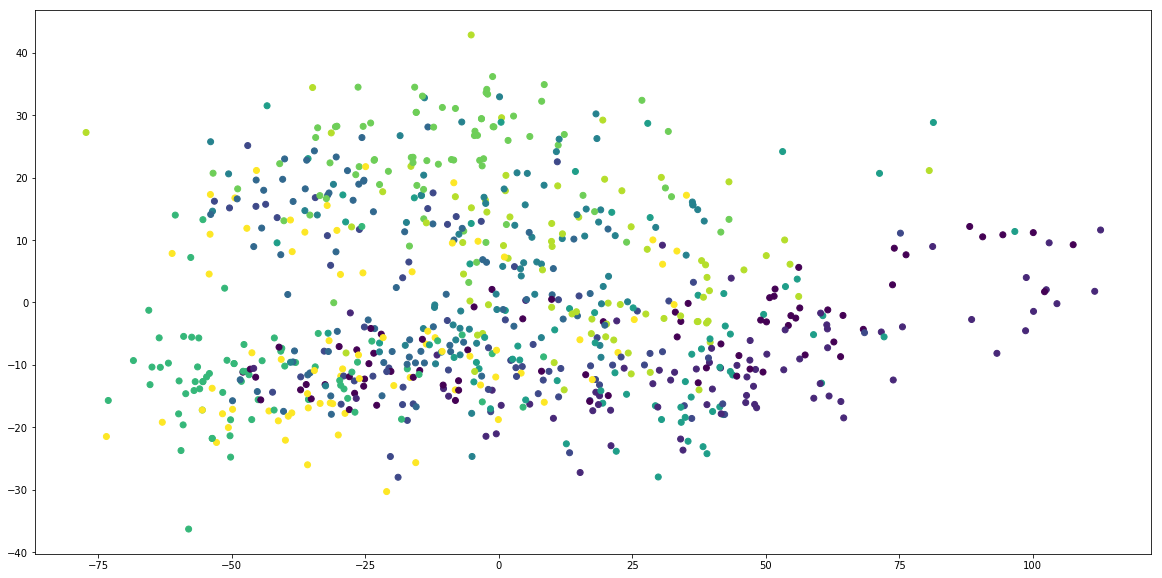

In [10]:
plt.figure(figsize=(20,10))
plt.scatter(X_pca[:,0], X_pca[:,1], c = y_train)
plt.show()

Guardamos los datos para tener una representación en: https://projector.tensorflow.org/

In [11]:
def obtener_nombre_genero(numero):
    generos = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    return generos[int(numero)]

with open('../results/embedding-projector/records_before.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    for row in X_pca:
        writer.writerow(row)
    tsvfile.close() 

with open('../results/embedding-projector/metadata_before.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    writer.writerow(['ID', 'GENERO'])
    for row in y_train:
        writer.writerow([row, obtener_nombre_genero(row)])
    tsvfile.close()

Calcularemos el PCA con el modelo ya entrenado

In [12]:
from keras.models import model_from_json, Model

with open('../results/best-model/model.json') as f:
    config_model = f.read()
    
model = model_from_json(config_model)
model.load_weights('../results/best-model/weights.hdf5')

new_model = Model(model.inputs, model.layers[-3].output)
new_model.set_weights(model.get_weights())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
embedding = new_model.predict(X_train)

In [14]:
pca = PCA(n_components = 350)
embedding_350 = pca.fit_transform(embedding)

with open('../results/embedding-projector/records.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    for row in embedding_350:
        writer.writerow(row)
    tsvfile.close() 
    
with open('../results/embedding-projector/metadata.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    writer.writerow(['ID', 'GENERO'])
    for row in y_train:
        writer.writerow([row, obtener_nombre_genero(row)])
    tsvfile.close()

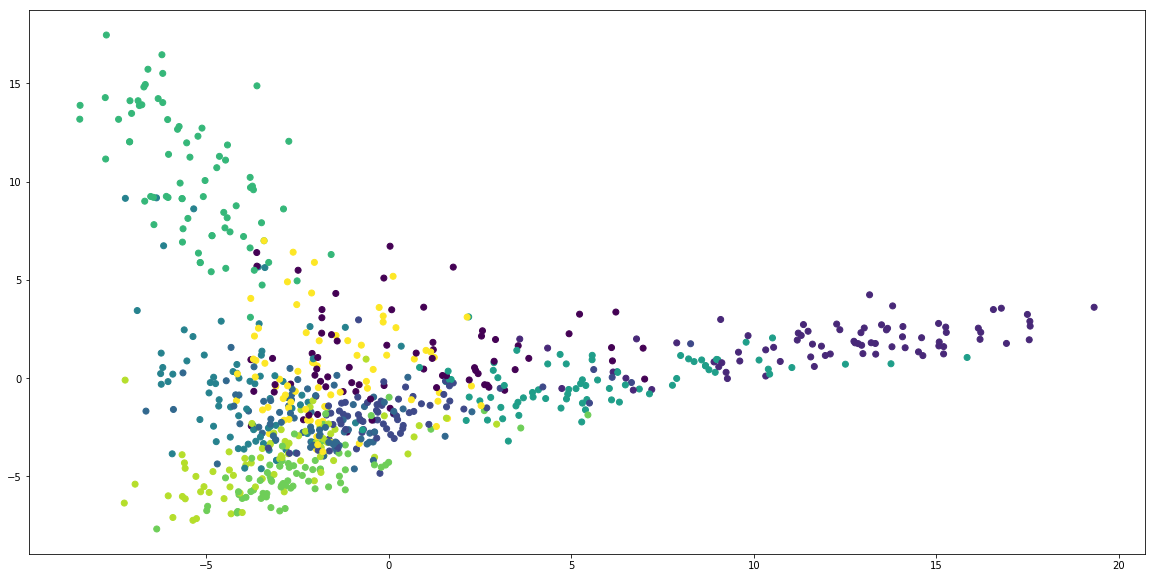

In [15]:
plt.figure(figsize=(20,10))
plt.scatter(embedding_350[:,0], embedding_350[:,1], c = y_train)
plt.show()

Como se puede observar nuestro modelo ha conseguido agrupar los datos, por lo que se obtendrán buenos valores de clasificación